# &#x1F4D1; &nbsp;  Build  a  Digit Recognition Models

## Links
Multi-dimensional image processing https://docs.scipy.org/doc/scipy/reference/ndimage.html

Keras: Deep Learning library for Theano and TensorFlow https://keras.io/
 
Deep MNIST for Experts https://www.tensorflow.org/get_started/mnist/pros

Tensorflow Deep MNIST Advanced Tutorial http://docs.seldon.io/tensorflow-deep-mnist-example.html

Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras

http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

## Libraries

In [391]:
import numpy as np
import scipy as sp
import pandas as pd
from time import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import matplotlib.cm as cm

%matplotlib inline

In [2]:
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn import manifold, decomposition, ensemble
from sklearn import discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split

In [30]:
import tensorflow as tf

import keras as ks
from keras.models import Sequential, load_model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

## Dataset

In [4]:
df_train = pd.read_csv("kaggle_train.csv")
df_test = pd.read_csv("kaggle_test.csv")

In [5]:
df_train.shape

(42000, 785)

In [6]:
df_train.ix[:,0:10].head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0


In [7]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
train_images = np.array(df_train[images])
train_images.shape

(42000, 784)

In [8]:
train_labels = df_train['label']
train_labels10 = np.array(ks.utils.to_categorical(train_labels, num_classes=10))
train_labels10.shape

(42000, 10)

In [9]:
test_images = np.array(df_test[images])
test_images.shape

(28000, 784)

In [10]:
train_images28 = np.array([np.reshape(x, (28, 28)) for x in train_images])
test_images28 = np.array([np.reshape(x, (28, 28)) for x in test_images])
train_images28n = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images28n = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_images28n, train_labels10, 
                                                 test_size=0.20, random_state=32)

In [12]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_images, train_labels10, 
                                                 test_size=0.20, random_state=32)

In [191]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(train_images, train_labels, 
                                                 test_size=0.20, random_state=32)

## Examples

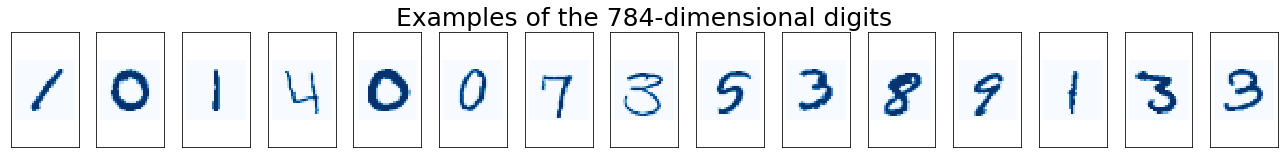

In [13]:
fig, ax = plt.subplots(figsize=(18, 2), nrows=1, ncols=15, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(15):
    image = train_images28[i]
    ax[i].imshow(image, cmap=plt.cm.Blues)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[7].set_title('Examples of the 784-dimensional digits', fontsize=25);

## Models

***Model #1. Convolutional Neural Network. Keras***

In [398]:
def cnn_model11():
    model = Sequential()
    
    model.add(Conv2D(filters = 28, kernel_size = (5, 5), activation='relu',
                     input_shape = (28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 56, kernel_size = (5, 5), activation='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
#    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [399]:
cnn_model11 = cnn_model11()

fit11 = cnn_model11.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=10, batch_size=64, verbose=2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
95s - loss: 0.2201 - acc: 0.9343 - val_loss: 0.0674 - val_acc: 0.9794
Epoch 2/10
91s - loss: 0.0736 - acc: 0.9770 - val_loss: 0.0393 - val_acc: 0.9882
Epoch 3/10
90s - loss: 0.0592 - acc: 0.9815 - val_loss: 0.0384 - val_acc: 0.9889
Epoch 4/10
92s - loss: 0.0457 - acc: 0.9854 - val_loss: 0.0347 - val_acc: 0.9906
Epoch 5/10
90s - loss: 0.0421 - acc: 0.9861 - val_loss: 0.0406 - val_acc: 0.9879
Epoch 6/10
89s - loss: 0.0329 - acc: 0.9891 - val_loss: 0.0368 - val_acc: 0.9892
Epoch 7/10
92s - loss: 0.0320 - acc: 0.9896 - val_loss: 0.0404 - val_acc: 0.9888
Epoch 8/10
95s - loss: 0.0283 - acc: 0.9907 - val_loss: 0.0419 - val_acc: 0.9898
Epoch 9/10
94s - loss: 0.0265 - acc: 0.9913 - val_loss: 0.0407 - val_acc: 0.9912
Epoch 10/10
94s - loss: 0.0280 - acc: 0.9908 - val_loss: 0.0384 - val_acc: 0.9917


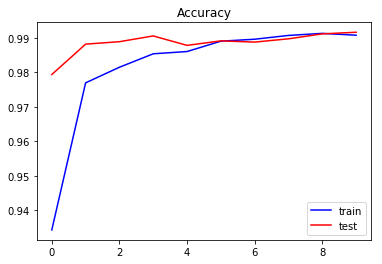

In [400]:
plt.plot(fit11.history['acc'], color='b', label = 'train')
plt.plot(fit11.history['val_acc'], color='r', label = 'test')
plt.legend()
plt.title('Accuracy');

In [401]:
cnn_scores1 = cnn_model11.evaluate(X_test, y_test, verbose=0)

print("Model 1. CNN Scores: " , (cnn_scores1))
print("Model 1. CNN Error: %.2f%%" % (100 - cnn_scores1[1]*100))
print(cnn_model11.summary())

Model 1. CNN Scores:  [0.038439843593930295, 0.9916666666666667]
Model 1. CNN Error: 0.83%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 24, 24, 28)        728       
_________________________________________________________________
batch_normalization_17 (Batc (None, 24, 24, 28)        112       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 56)          39256     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 4, 4, 56)          0         
___________________________________________________

***Model #2. Multi-layer Perceptron. Keras***

In [413]:
mlp_model = Sequential()

mlp_model.add(Dense(28, activation='relu', input_dim=784))
mlp_model.add(Dense(56, activation='relu'))

mlp_model.add(Dropout(0.05))

mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dense(128, activation='relu'))

mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dense(256, activation='relu'))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(512, activation='relu'))


mlp_model.add(Dense(10, activation='softmax'))

mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

fit12 = mlp_model.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), 
                      epochs=25, batch_size=64, verbose=2);

Train on 33600 samples, validate on 8400 samples
Epoch 1/25
17s - loss: 0.6589 - acc: 0.7985 - val_loss: 0.2918 - val_acc: 0.9164
Epoch 2/25
12s - loss: 0.2959 - acc: 0.9146 - val_loss: 0.2376 - val_acc: 0.9306
Epoch 3/25
12s - loss: 0.2272 - acc: 0.9358 - val_loss: 0.2112 - val_acc: 0.9427
Epoch 4/25
11s - loss: 0.1984 - acc: 0.9450 - val_loss: 0.1949 - val_acc: 0.9425
Epoch 5/25
11s - loss: 0.1842 - acc: 0.9479 - val_loss: 0.2035 - val_acc: 0.9465
Epoch 6/25
12s - loss: 0.1665 - acc: 0.9537 - val_loss: 0.1757 - val_acc: 0.9518
Epoch 7/25
12s - loss: 0.1523 - acc: 0.9574 - val_loss: 0.2101 - val_acc: 0.9475
Epoch 8/25
12s - loss: 0.1493 - acc: 0.9580 - val_loss: 0.1772 - val_acc: 0.9525
Epoch 9/25
11s - loss: 0.1306 - acc: 0.9624 - val_loss: 0.1764 - val_acc: 0.9574
Epoch 10/25
11s - loss: 0.1303 - acc: 0.9645 - val_loss: 0.1979 - val_acc: 0.9526
Epoch 11/25
12s - loss: 0.1245 - acc: 0.9646 - val_loss: 0.1501 - val_acc: 0.9590
Epoch 12/25
11s - loss: 0.1105 - acc: 0.9693 - val_loss: 0

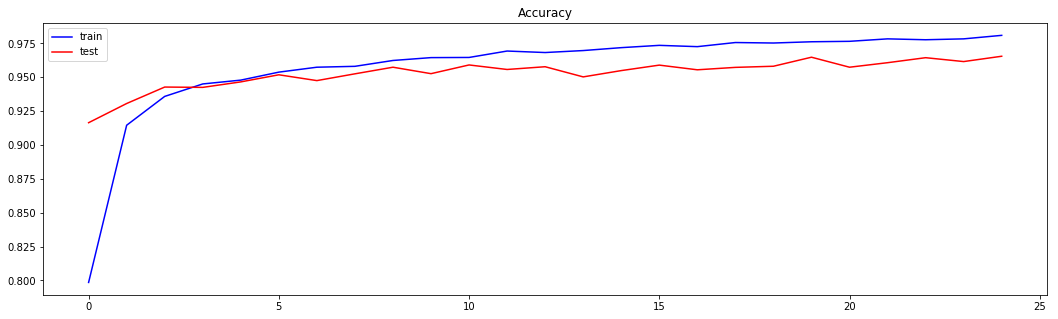

In [414]:
plt.figure(figsize=(18,5))
plt.plot(fit12.history['acc'], color='b', label = 'train')
plt.plot(fit12.history['val_acc'], color='r', label = 'test')
plt.legend()
plt.title('Accuracy');

In [415]:
mlp_scores = mlp_model.evaluate(X_test2, y_test2)
print("\nMLP Scores: ", (mlp_scores))
print("MLP Error: %.2f%%" % (100 - mlp_scores[1] * 100))
print(mlp_model.summary())

8224/8400 [============================>.] - ETA: 0s

***Model #3. MLPClassifier. Scikit-learn***

In [354]:
clf1 = MLPClassifier(hidden_layer_sizes=(600,), max_iter=20, alpha=1e-4,
                     solver='adam', verbose=10, tol=1e-5, random_state=1,
                     learning_rate_init=7e-4)
clf1.fit(X_train3, y_train3);

Iteration 1, loss = 2.31315193
Iteration 2, loss = 0.83616509
Iteration 3, loss = 0.51653195
Iteration 4, loss = 0.34710206
Iteration 5, loss = 0.24998327
Iteration 6, loss = 0.21335697
Iteration 7, loss = 0.17443618
Iteration 8, loss = 0.16574088
Iteration 9, loss = 0.11549613
Iteration 10, loss = 0.13282783
Iteration 11, loss = 0.13285966
Iteration 12, loss = 0.11034855
Iteration 13, loss = 0.13353589
Iteration 14, loss = 0.10949534
Iteration 15, loss = 0.09237345
Iteration 16, loss = 0.07814441
Iteration 17, loss = 0.08594499
Iteration 18, loss = 0.09234009
Iteration 19, loss = 0.09659960
Training loss did not improve more than tol=0.000010 for two consecutive epochs. Stopping.


In [355]:
print("MNIST. MLPClassifier. Train score: %f" % (clf1.score(X_train3, y_train3)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf1.score(X_test3, y_test3)*100),'%')

MNIST. MLPClassifier. Train score: 99.467262 %
MNIST. MLPClassifier. Test score: 97.238095 %


In [385]:
clf2 = MLPClassifier(hidden_layer_sizes=(700,), max_iter=50, alpha=1e-4,
                     solver='adam', verbose=1, tol=1e-6, random_state=1,
                     learning_rate_init=7e-4, batch_size=512)
clf2.fit(X_train3, y_train3);

Iteration 1, loss = 3.58473858
Iteration 2, loss = 1.05612829
Iteration 3, loss = 0.68462342
Iteration 4, loss = 0.44562329
Iteration 5, loss = 0.28505294
Iteration 6, loss = 0.19565528
Iteration 7, loss = 0.13543079
Iteration 8, loss = 0.11569771
Iteration 9, loss = 0.10907456
Iteration 10, loss = 0.07680233
Iteration 11, loss = 0.06425055
Iteration 12, loss = 0.04907902
Iteration 13, loss = 0.03462082
Iteration 14, loss = 0.03643879
Iteration 15, loss = 0.04755142
Iteration 16, loss = 0.08535340
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.


In [386]:
print("MNIST. MLPClassifier. Train score: %f" % (clf2.score(X_train3, y_train3)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf2.score(X_test3, y_test3)*100),'%')

MNIST. MLPClassifier. Train score: 99.434524 %
MNIST. MLPClassifier. Test score: 96.059524 %


## Predictions

In [402]:
predict_labels1 = cnn_model11.predict_classes(test_images28n)

28000/28000 [==============================] - 41s       

In [407]:
predict_labels2 = mlp_model.predict_classes(test_images)

27936/28000 [============================>.] - ETA: 0s   

In [330]:
predict_labels3 = clf1.predict(test_images)

In [403]:
submission1 = pd.DataFrame({"ImageId": range(1, len(predict_labels1)+1), "Label": predict_labels1})
print(submission1[0:50])

submission1.to_csv('kaggle_digits_model1_2.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0
20       21      9
21       22      1
22       23      1
23       24      5
24       25      7
25       26      4
26       27      2
27       28      7
28       29      4
29       30      7
30       31      7
31       32      5
32       33      4
33       34      2
34       35      6
35       36      2
36       37      5
37       38      5
38       39      1
39       40      6
40       41      7
41       42      7
42       43      4
43       44      9
44       45      8
45       46      7
46       47      8
47       48      2
48       49      6
49       50      7


In [408]:
submission2 = pd.DataFrame({"ImageId": range(1, len(predict_labels2)+1), "Label": predict_labels2})
print(submission2[0:20])

submission2.to_csv('kaggle_digits_model2.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [331]:
submission3 = pd.DataFrame({"ImageId": range(1, len(predict_labels3)+1), "Label": predict_labels3})
print(submission3[0:50])

submission3.to_csv('kaggle_digits_model3.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0
20       21      9
21       22      1
22       23      1
23       24      5
24       25      7
25       26      4
26       27      2
27       28      7
28       29      4
29       30      7
30       31      7
31       32      5
32       33      4
33       34      2
34       35      6
35       36      2
36       37      5
37       38      5
38       39      1
39       40      6
40       41      7
41       42      7
42       43      4
43       44      9
44       45      8
45       46      7
46       47      8
47       48      2
48       49      6
49       50      7


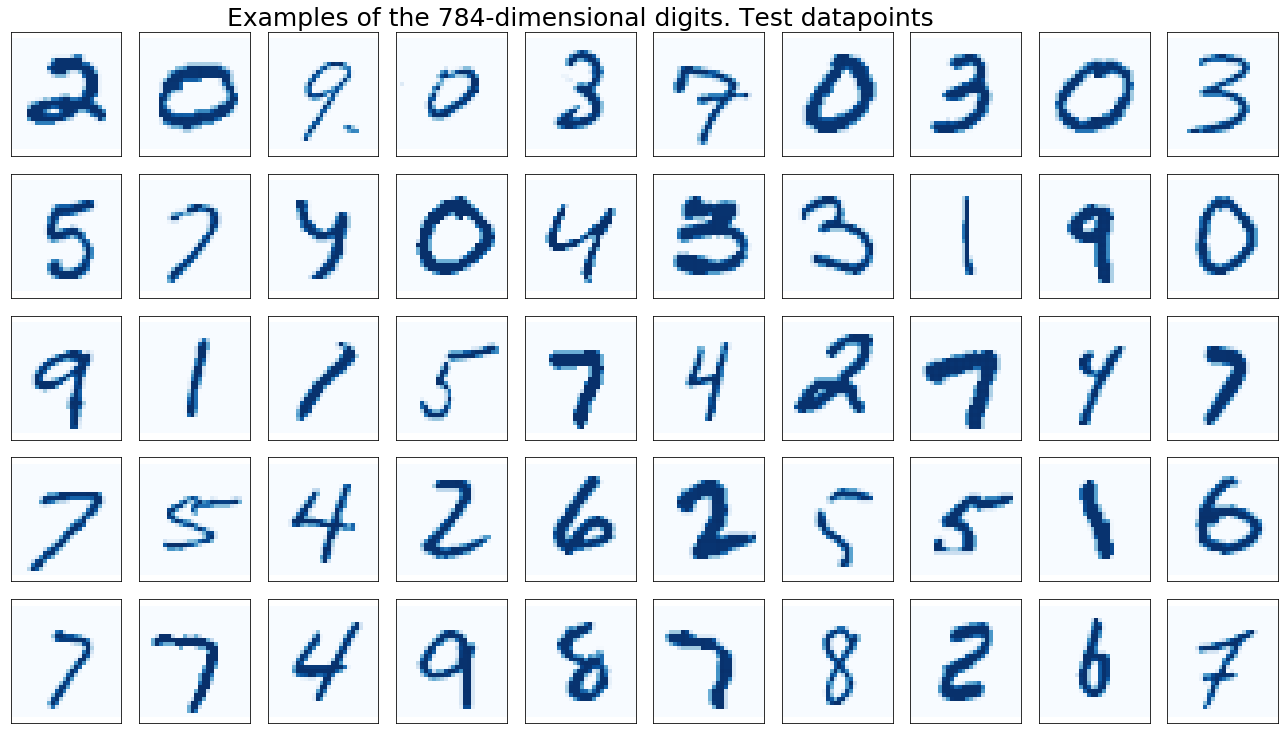

In [253]:
fig, ax = plt.subplots(figsize=(18, 10), nrows=5, ncols=10, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(50):
    image = test_images28[i]
    ax[i].imshow(image, cmap=plt.cm.Blues)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[4].set_title('Examples of the 784-dimensional digits. Test datapoints', fontsize=25);